### What is probabilistic programming?

Probabilistic programming allow programmers to treat **variables as random variables**.

Particularly, it allows you to express probabilistic models in statistics and machine learning in a structured way, and run these models with generic inference algorithms such as importance sampling, Metropolis-Hastings, SMC, HMC.

Generally,
* Develop a new probabilistic model.
* Design an inference algorithm for the model.
* Using the algorithm, fit the model to the data.

Using a probabilistic programming language,
* Develop a new probabilistic model as a program.
* Using a generic inference algorithm of the language, fit the model to the data.

In [1]:
!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro

In [2]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax
import jax.numpy as jnp
import scipy.stats as stats
from jax import random

### Example 1: Coin toss

Consider a coin toss example, where $x$ is the bias of the coin and $y$ is the value of the flipped coin.

\begin{equation}
x \sim \text{Beta}(\alpha, \beta) \\
y \sim \text{Binomial}(x, N)
\end{equation}

$\alpha, \beta$ are parameters. We encode the event of heads as $y$, which takes value $1$ or $0$ otherwise, $x \in [0, 1]$.

\begin{equation}
p(x, y) = x^y(1 - x)^{N-y} \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} x^{\alpha-1}(1 - x)^{\beta-1}
\end{equation}

\begin{equation}
p(x, y) = \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} x^{y+\alpha-1} (1 - x)^{N + \beta-y - 1}
\end{equation}

The conditional distribution can written as

\begin{align}
p(x | y) = \frac{p(x, y)}{\int p(x, y) \, dx} &= \frac{\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha) \Gamma(\beta)} x^{y+\alpha-1} (1 - x)^{N + \beta-y - 1}}{\int \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha) \Gamma(\beta)} x^{y+\alpha-1} (1 - x)^{N + \beta-y - 1} \, dx} \\
 &= \frac{x^{y+\alpha-1} (1 - x)^{N + \beta-y - 1}}{\int x^{y+\alpha-1} (1 - x)^{N + \beta-y - 1} \, dx}
\end{align}

Due to conjugacy,
\begin{equation}
\int x^{y+\alpha-1}(1 - x)^{N + \beta-y - 1} \, dx = \frac{\Gamma(\alpha + y)\Gamma(N + \beta - y)}{\Gamma(\alpha + \beta + 1)}.
\end{equation}

Thus,
\begin{align}
p(x|y) &= \text{Beta}(y+\alpha, N + \beta - y), \\
x|y &\sim \text{Beta}(y+\alpha, N + \beta - y).
\end{align}

* We usually won’t be so lucky that the normalizing integral has an algebraic analytic solution nor will it usually be easily calculable numerically. The fundamental problem is that we are often unable to evaluate this integral analytically and so we must turn to a numerical approximation method instead.
* An additional problem is that our models might require a large number of parameters. This means that our prior distributions could potentially have a large number of dimensions. This in turn means that our posterior distributions will also be high dimensional. Hence, we are in a situation where we have to numerically evaluate an integral in a potentially very large dimensional space. Thus we are in a situation often described as the Curse of Dimensionality.


In [3]:
def coin_toss_model(data=None):
    # Prior distribution for the probability of heads
    p = numpyro.sample("p", dist.Beta(12, 12))

    # Likelihood of the observed data
    with numpyro.plate("data", size=len(data)):
        numpyro.sample("obs", dist.Bernoulli(probs=p), obs=data)

### Numpyro basics

* **```numpyro.sample```** -- We call the numpyro.sample to create a random variable to use as a Beta prior. The first argument is always the name of the random variable, which should almost always match the name of the Python variable being assigned to, since it is sometimes used to retrieve the variable from the model for summarizing output.

* The final line of the model defines obs, the sampling distribution of the outcomes in the dataset. This is a special case of a stochastic variable that we call an **observed stochastic**, and represents the data likelihood of the model. It is identical to a standard stochastic, except that its observed argument, which passes the data to the variable, indicates that the values for this variable were observed, and should not be changed by any fitting algorithm applied to the model. The data can be passed in the form of either a ndarray or DataFrame object.
* We're using a **```numpyro.plate```** to indicate that the data are independent.

### Why simulation?
Simulation based algorithms are necessary because for many real-world high-dimensional data we cannot analytically compute the posterior distribution according to Bayes’ Theorem. Simulation based sampling methods like Markov Chain Monte Carlo algorithms can generate samples from the posterior distribution.



In [4]:
from numpyro.infer import MCMC, NUTS

In [5]:
true_p = 0.3  # True probability of heads
data = jax.random.bernoulli(key=jax.random.PRNGKey(0), p=true_p, shape=(1000,))
## What NUTS is and how it used
nuts_kernel = NUTS(coin_toss_model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=2000)
mcmc.run(random.PRNGKey(1), data=data)

sample: 100%|██████████| 2500/2500 [00:02<00:00, 944.85it/s, 1 steps of size 1.19e+00. acc. prob=0.88] 


After running the MCMC algorithm, we can extract and analyze the posterior samples:

In [6]:
# Analyzing results
samples = mcmc.get_samples()
## Tell what p is and how it gets it
p_mean = jnp.mean(samples['p'])
p_std = jnp.std(samples['p'])
print(f"Posterior mean of p: {p_mean:.2f}")
print(f"Posterior std of p: {p_std:.2f}")

Posterior mean of p: 0.29
Posterior std of p: 0.01


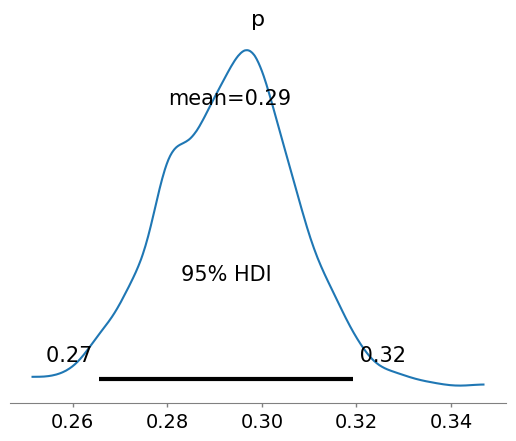

In [8]:
import arviz as az
import matplotlib.pyplot as plt

az.plot_posterior(samples, var_names=["p"], hdi_prob=0.95)
plt.show()

The left plot consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right figure contains the samples of the Markov chain plotted in sequential order.

array([[<Axes: title={'center': 'p'}>, <Axes: title={'center': 'p'}>]],
      dtype=object)

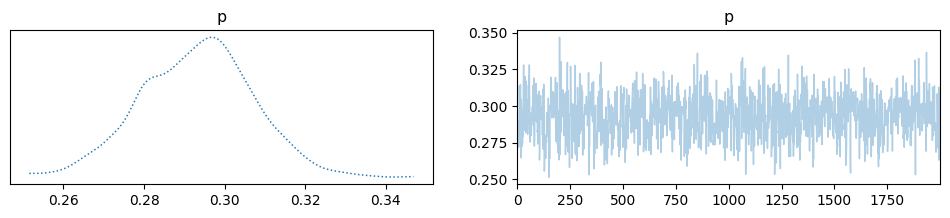

In [9]:
az.plot_trace(samples, combined=True)

In [10]:
def plot_mcmc_comparison(trace, bins, alpha, beta, alpha_post, beta_post):
    # Plot the posterior histogram from MCMC analysis
    plt.hist(
        trace['p'], bins,
        histtype="step", density=True,
        label="Posterior (MCMC)", color="red"
    )

    # Plot the analytic prior and posterior beta distributions
    x = jnp.linspace(0, 1, 1000)
    plt.plot(
        x, stats.beta.pdf(x, alpha, beta),
        "--", label="Prior", color="blue"
    )
    plt.plot(
        x, stats.beta.pdf(x, alpha_post, beta_post),
        label='Posterior (Analytic)', color="green"
    )

    # Update the graph labels
    plt.legend(title="Parameters", loc="best")
    plt.xlabel("$\\theta$, Fairness")
    plt.ylabel("Density")
    plt.show()

    # Display the plot
    plt.show()

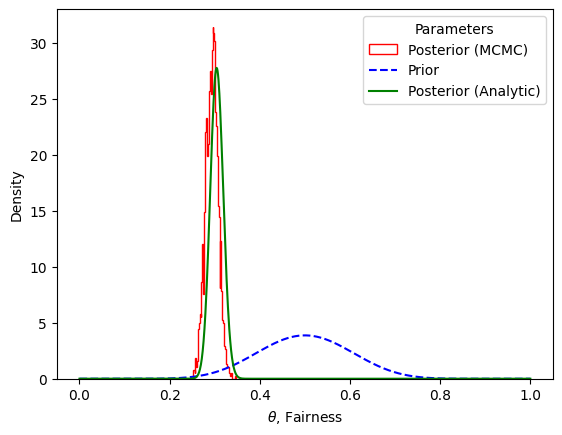

In [11]:
# Parameter values for prior and analytic posterior
n = 1000. ## Number of flips
y = 300. ## Number of heads
alpha = 12
beta = 12
alpha_post = y + alpha
beta_post = n - y + beta


# Number of Bins for Histogram
bins = 50

# mcmc_model = create_mcmc_model(alpha, beta, n, z, iterations)
plot_mcmc_comparison(samples, bins, alpha, beta, alpha_post, beta_post)